In [1]:
library(dplyr)
library(tidyr)
library(stringr)
library(ggplot2)
library(ggpubr)
library(kedd)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




## Load and format protein sequence file (sequences downloaded from UniProtKB)

In [2]:
# On bash command line:
# tr -d '\n' < file.fasta > file_noN.fasta  ## This deletes \n from file (file is now 1 loooooong line)

# Notes: '\n' (new line) might need to be '\r' (return). .fasta file can also be .txt

In [2]:
# Read file and separate based on > symbol (which is at the beginning of each gene header)
protein_seq <- read.delim("file_noN.fasta", header = F, sep = ">")
#head(protein_seq)

# Above command make a table with 1 column per gene+seq. Transpose and transform to data frame for 1 row per gene+seq. 
protein_rows <- as.data.frame(t(protein_seq))
#head(protein_rows)

# Separate gene name and gene into separate columns. 
protein_divide <- separate(protein_rows, V1, c("Gene", "AA_seq"), sep = "_name")
# Remove first row (just says "NA")
protein_divide <- protein_divide[-1,]

head(protein_divide)
dim(protein_divide)

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '~/Desktop/Data/Daniel_Halofuginone/OtherViruses_Panalysis/dengue_noN.fasta'”


,Gene,AA_seq
,<chr>,<chr>
V2,POLG,MNNQRKKTGRPSFNMLKRARNRVSTVSQLAKRFSKGLLSGQGPMKLVMAFIAFLRFLAIPPTAGILARWGSFKKNGAIKVLRGFKKEISNMLNIMNRRKRSVTMLLMLLPTALAFHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGELCEDTMTYKCPRITETEPDDVDCWCNATETWVTYGTCSQTGEHRRDKRSVALAPHVGLGLETRTETWMSSEGAWKQIQKVETWALRHPGFTVIALFLAHAIGTSITQKGIIFILLMLVTPSMAMRCVGIGNRDFVEGLSGATWVDVVLEHGSCVTTMAKDKPTLDIELLKTEVTNPAVLRKLCIEAKISNTTTDSRCPTQGEATLVEEQDTNFVCRRTFVDRGWGNGCGLFGKGSLITCAKFKCVTKLEGKIVQYENLKYSVIVTVHTGDQHQVGNETTEHGTTATITPQAPTSEIQLTDYGALTLDCSPRTGLDFNEMVLLTMEKKSWLVHKQWFLDLPLPWTSGASTSQETWNRQDLLVTFKTAHAKKQEVVVLGSQEGAMHTALTGATEIQTSGTTTIFAGHLKCRLKMDKLTLKGMSYVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSSQDEKGVTQNGRLITANPIVTDKEKPVNIEAEPPFGESYIVVGAGEKALKLSWFKKGSSIGKMFEATARGARRMAILGDTAWDFGSIGGVFTSVGKLIHQIFGTAYGVLFSGVSWTMKIGIGILLTWLGLNSRSTSLSMTCIAVGMVTLYLGVMVQADSGCVINWKGRELKCGSGIFVTNEVHTWTEQYKFQADSPKRLSAAIGKAWEEGVCGIRSATRLENIMWKQISNELNHILLENDMKFTVVVGDVSGILAQGKKMIRPQPMEHKYSWKSWGKAKIIGADVQNTTFIIDGPNTPECPDNQRAWNIWEVEDYGFGIFTTNIWLKLRDSYTQVCDHRLMSAAIKDSKAVHADMGYWIESEKNETWKLARASFIEVKTCIWPKSHTLWSNGVLESEMIIPKIYGGPISQHNYRPGYFTQTAGPWHLGKLELDFDLCEGTTVVVDEHCGNRGPSLRTTTVTGKTIHEWCCRSCTLPPLRFKGEDGCWYGMEIRPVKEKEENLVKSMVSAGSGEVDSFSLGLLCISIMIEEVMRSRWSRKMLMTGTLAVFLLLTMGQLTWNDLIRLCIMVGANASDKMGMGTTYLALMATFRMRPMFAVGLLFRRLTSREVLLLTVGLSLVASVELPNSLEELGDGLAMGIMMLKLLTDFQSHQLWATLLSLTFVKTTFSLHYAWKTMAMILSIVSLFPLCLSTTSQKTTWLPVLLGSLGCKPLTMFLITENKIWGRKSWPLNEGIMAVGIVSILLSSLLKNDVPLAGPLIAGGMLIACYVISGSSADLSLEKAAEVSWEEEAEHSGASHNILVEVQDDGTMKIKDEERDDTLTILLKATLLAISGVYPMSIPATLFVWYFWQKKKQRSGVLWDTPSPPEVERAVLDDGIYRILQRGLLGRSQVGVGVFQEGVFHTMWHVTRGAVLMYQGKRLEPSWASVKKDLISYGGGWRFQGSWNAGEEVQVIAVEPGKNPKNVQTAPGTFKTPEGEVGAIALDFKPGTSGSPIVNREGKIVGLYGNGVVTTSGTYVSAIAQAKASQEGPLPEIEDEVFRKRNLTIMDLHPGSGKTRRYLPAIVREAIRRNVRTLVLAPTRVVASEMAEALKGMPIRYQTTAVKSEHTGKEIVDLMCHATFTMRLLSPVRVPNYNMIIMDEAHFTDPASIAARGYISTRVGMGEAAAIFMTATPPGSVEAFPQSNAVIQDEERDIPERSWNSGYDWITDFPGKTVWFVPSIKSGNDIANCLRKNGKRVVQLSRKTFDTEYQKTKNNDWDYVVTTDISEMGANFRADRVIDPRRCLKPVILKDGPERVILAGPMPVTVASAAQRRGRIGRNQNKEGDQYIYMGQPLNNDEDHAHWTEAKMLLDNINTPEGIIPALFEPEREKSAAIDGEYRLRGEARKTFVELMRRGDLPVWLSYKVASEGFQYSDRRWCFDGERNNQVLEENMDVEIWTKEGERKKLRPRWLDARTYSDPLALREFKEFAAGRRSVSGDLILEIGKLPQHLTQRAQNALDNLVMLHNSEQGGKAYRHAMEELPDTIETLMLLALIAVLTGGVTLFFLSGRGLGKTSIGLLCVIASSALLWMASVEPHWIAASIILEFFLMVLLIPEPDRQRTPQDNQLAYVVIGLLFMILTAAANEMGLLETTKKDLGIGHAAAENHHHAAMLDVDLHPASAWTLYAVATTIITPMMRHTIENTTANISLTAIANQAAILMGLDKGWPISKMDIGVPLLALGCYSQVNPLTLTAAVFMLVAHYAIIGPGLQAKATREAQKRTAAGIMKNPTVDGIVAIDLDPVVYDAKFEKQLGQIMLLILCTSQILLMRTTWALCESITLATGPLTTLWEGSPGKFWNTTIAVSMANIFRGSYLAGAGLAFSLMKSLGGGRRGTGAQGETLGEKWKRQLNQLSKSEFNTYKRSGIIEVDRSEAKEGLKRGEPTKHAVSRGTAKLRWFVERNLVKPEGKVIDLGCGRGGWSYYCAGLKKVTEVKGYTKGGPGHEEPIPMATYGWNLVKLYSGKDVFFTPPEKCDTLLCDIGESSPNPTIEEGRTLRVLKMVEPWLRGNQFCIKILNPYMPSVVETLEQMQRKHGGMLVRNPLSRNSTHEMYWVSCGTGNIVSAVNMTSRMLLNRFTMAHRKPTYERDVDLGAGTRHVAVEPEVANLDIIGQRIENIKNGHKSTWHYDEDNPYKTWAYHGSYEVKPSGSASSMVNGVVRLLTKPWDVIPMVTQIAMTDTTPFGQQRVFKEKVDTRTPKAKRGTAQIMEVTARWLWGFLSRNKKPRICTREEFTRKVRSNAAIGAVFVDENQWNSAKEAVEDERFWDLVHRERELHKQGKCATCVYNMMGKREKKLGEFGKAKGSRAIWYMWLGARFLEFEALGFMNEDHWFSRENSLSGVEGEGLHKLGYILRDISKIPGGNMYADDTAGWDTRITEDDLQNEAKITDIMEPEHALLATSIFKLTYQNKVVRVQRPAKNGTVMDVISRRDQRGSGQVGTYGLNTFTNMEAQLIRQMESEGIFSPSELETPNLAERVLDWLKKHGTERLKRMAISGDDCVVKPIDDRFATALTALNDMGKVRKDIPQWEPSKGWNDWQQVPFCSHHFHQLIMKDGREIVVPCRNQDELVGRARVSQGAGWSLRETACLGKSYAQMWQLMYFHRRDLRLAANAICSAVPVDWVPTSRTTWSIHAHHQWMTTEDMLSVWNRVWIEENPWMEDKTHVSSWEDVPYLGKREDRWCGSLIGLTARATWATNIQVAINQVRRLIGNENYLDFMTSMKRFKNESDPEGALW


[1] 1 2

In [3]:
# Command to count and get location of each P in sequence. Get output as a data frame of 2 columns and P rows. 
Gene1 <- data.frame(str_locate_all(protein_divide[1,2], pattern = "P"))
head(Gene1)

,start,end
,<int>,<int>
1,84,84
2,135,135
3,138,138
4,146,146
5,178,178
6,235,235


In [3]:
# Function to make matrix of P locations in each gene (each gene = 1 column)
analyze <- function(df) {
    out <- matrix(ncol = length(df$Gene), nrow = 2000) # Create matrix for data deposition
    for (f in 1:nrow(df)) {
        fdata <- df[f,2] # Define row f, column 2 as variable fdata
        fcount <- data.frame(str_locate_all(fdata, pattern = "P")) # Define fcount as data frame of P locations
        out[1:nrow(fcount),f] <- fcount$start # Add list of P locations to matrix out in column f
    }
    return(out)
}

# Run function
protein_Pcount <- analyze(protein_divide)

# Set column names of matrix output
colnames(protein_Pcount) <- protein_divide$Gene
#colnames(protein_Pcount)

# Transform matrix to data frame.
protein_Pcount_df <- data.frame(protein_Pcount) 
head(protein_Pcount_df)

,POLG
,<int>
1,11
2,43
3,60
4,61
5,110
6,124


## Percent proline and P score calculation for each protein

In [1]:
# Number of AA in each protein
AA_number <- apply(protein_divide, 2, nchar)
head(AA_number)

# Number of prolines in each protein
P_number <- str_count(protein_divide[,2], "P")
P_number

# Combine number of AA and number of P in table
AA_P_number <- as.data.frame(AA_number)
AA_P_number$P_n <- P_number
#head(AA_P_number)

# Calculate % proline
AA_P_percent <- mutate(AA_P_number, P_percent = P_n/AA_seq)
# Add column with gene name
AA_P_percent$Gene_name <- protein_divide$Gene

AA_P_percent

ERROR: Error in apply(protein_divide, 2, nchar): object 'protein_divide' not found


In [2]:
# Calculate how many 10-AA blocks in each protein have 1 or more prolines
for (j in 1:nrow(protein_divide)){
    # Divide protein sequence into blocks of 10 and report (T/F) if any proline are present
    P_per10 <- sapply((substring(protein_divide[j,2], seq(1, nchar(protein_divide[j,2]), 10), seq(10, nchar(protein_divide[j,2]), 10))), function(i) str_detect(i, "P"))
    
    # Sum number of 10-AA sequences that contain prolines and add value to AA_P_percent data frame
                      ## Column called V6 here, called "Proline blocks" in Table S1
    AA_P_percent[j,6] <- sum(P_per10)
}


AA_P_percent$P_blocks_percent <- AA_P_percent$V6 / (AA_P_percent$AA_seq / 10)
AA_P_percent$Pblocks_x_Pn <- AA_P_percent$P_blocks_percent * AA_P_percent$P_n
AA_P_percent$P_score <- log10(AA_P_percent$P_per10_norm * AA_P_percent$P_n)
                      
AA_P_percent

ERROR: Error in mutate(AA_P_number, P_percent = P_n/AA_seq): could not find function "mutate"


In [6]:
#write.csv(AA_P_percent, "proline_percent.csv")

## Proline location plots with kernel density overlay

In [10]:
# Function for proline location plots (histogram with binwidth = 1) with kernel density plots overlaid
plots.histo1.density <- function(df) {
    for (i in 1:ncol(df)) {
       # Histogram
        histo <- ggplot(df, aes(x = df[,i])) +
        geom_histogram(binwidth = 1, color = "black", fill = "black") + 
        xlab("Amino acid position") + ylab("P probability density\n(kernel density est.)") +
        theme_classic() + ggtitle(colnames(df[i])) +
        scale_y_continuous(breaks = c()) +
        theme(axis.text.x = element_text(size = 6, family = "Arial", face = "bold", color = "black"), 
          axis.title.x = element_text(size = 6, family = "Arial", face = "bold"), 
          axis.text.y = element_blank(),
          axis.title.y = element_text(size = 6, family = "Arial", face = "bold"),
          plot.title = element_text(size = 6, family = "Arial", face = "bold"),
         axis.line = element_line(color = "black", size = 0.5)) +
        expand_limits(x = 0) 
    
        # Density plot of proline distribution
        xkd <- ggplot(df, aes(x = df[,i])) +
        geom_density(bw = h.mlcv(df[,i])$h, color = "red", fill = "red", alpha = 0.9, size = 0) +
        theme_transparent() + 
        theme(axis.text = element_blank(), 
          axis.title = element_blank()) +
        expand_limits(x = c(0, max(df[,i], na.rm = T)), y = 0)
        
        # Make density plot an external graphical object
        xkd_grob <- ggplotGrob(xkd)
        
        # Place density on top of histogram
        plot <- histo + annotation_custom(grob = xkd_grob, xmin = 0, xmax = max(df[,i], na.rm = T), 
                                          ymax = 0.7, ymin = -0.25)
        
        # Save plot
        ggsave(plot = last_plot(), file = paste0(colnames(df[i]), ".png"), width = 6.858, height = 3, units = "cm", dpi = 300)
        
        # Show plot in notebook
        print(plot)
    }
}

Warning message:
“Removed 1860 rows containing non-finite values (stat_density).”
Warning message:
“Removed 1860 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 1860 rows containing non-finite values (stat_bin).”


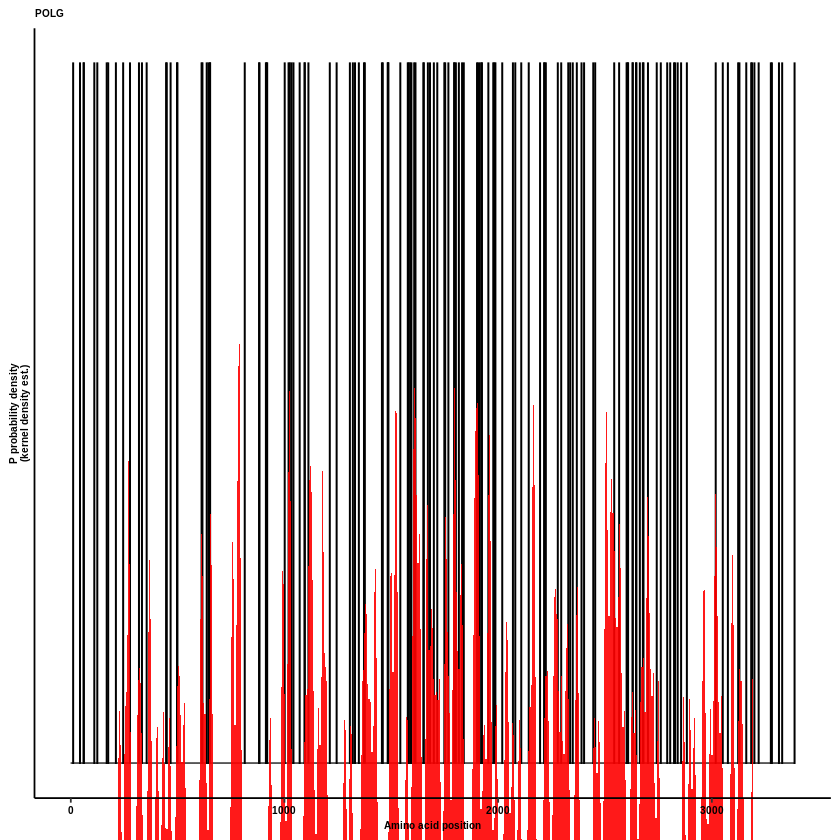

In [11]:
plots.histo1.density(protein_Pcount_df)